<a href="https://colab.research.google.com/github/buck06191/prototyping-notebooks/blob/main/autoencoder/autoencode_artefacts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, pairwise
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp


# Import spectral data

In [2]:
PATH = '/content/drive/MyDrive/test_data/raw_sensor_7.csv'
df = pd.read_csv(PATH)
control = df.loc[df['Artefact'] == 0]
light = df.loc[df['Artefact'].isin([5,6])]

In [3]:
def get_X(df):
    # Get and scale data
    signals = df.drop(['Artefact', 'Subject'], axis=1)
    X = signals.div(signals.max(axis=1), axis=0).values

    return X

In [4]:
control_X = get_X(control)
light_X = get_X(light)

[N_SAMPLES, N_WAVELENGTHS] = control_X.shape

Plot the data to check it looks sensible after scaling etc.

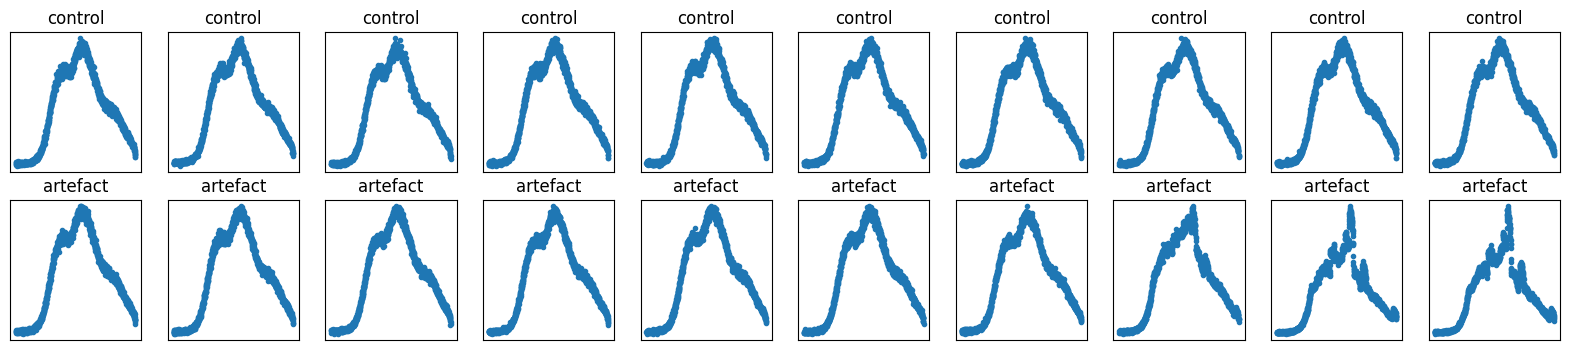

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display control
  ax = plt.subplot(2, n, i + 1)
  plt.plot(control_X[i,:], '.')
  plt.title("control")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display artefact
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(light_X[i,:], '.')
  plt.title("artefact")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# Autoencoder

Define an autoencoder with two Dense layers: an encoder, which compresses the spectra into a 64 dimensional latent vector, and a decoder, that reconstructs the original spectra from the latent space.

To define your model, use the Keras Model Subclassing API.

In [6]:
train_size = int(N_SAMPLES * 0.9)
x_train, x_test = tf.split(control_X, [train_size, N_SAMPLES - train_size])

In [7]:
latent_dim = 32 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        # layers.Dense(latent_dim * 2, activation='relu'),
        layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
        # layers.Dense(latent_dim * 2, activation='sigmoid'),

        layers.Dense(N_WAVELENGTHS, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

## Reproduction of spectra 

Start by looking at the performance of the autoencoder to reproduce clean control spectra

In [9]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
96/96 [==============================] - 5s 14ms/step - loss: 0.0182 - val_loss: 8.0722e-04
Epoch 2/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 5.9536e-04
Epoch 3/50
96/96 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 5.7247e-04
Epoch 4/50
96/96 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 6.0448e-04
Epoch 5/50
96/96 [==============================] - 1s 10ms/step - loss: 0.0010 - val_loss: 5.4178e-04
Epoch 6/50
96/96 [==============================] - 1s 6ms/step - loss: 9.5853e-04 - val_loss: 6.3222e-04
Epoch 7/50
96/96 [==============================] - 1s 6ms/step - loss: 7.6265e-04 - val_loss: 4.3775e-04
Epoch 8/50
96/96 [==============================] - 1s 7ms/step - loss: 5.2258e-04 - val_loss: 3.7530e-04
Epoch 9/50
96/96 [==============================] - 1s 8ms/step - loss: 3.7449e-04 - val_loss: 4.4970e-04
Epoch 10/50
96/96 [==============================] - 1s 7ms/ste

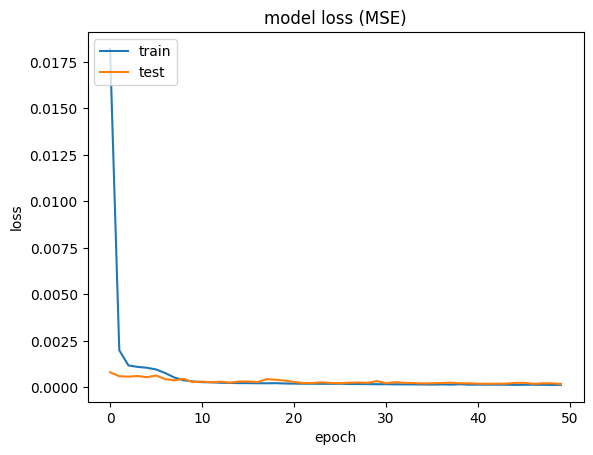

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
encoded_spectra = autoencoder.encoder(x_test).numpy()
decoded_spectra = autoencoder.decoder(encoded_spectra).numpy()

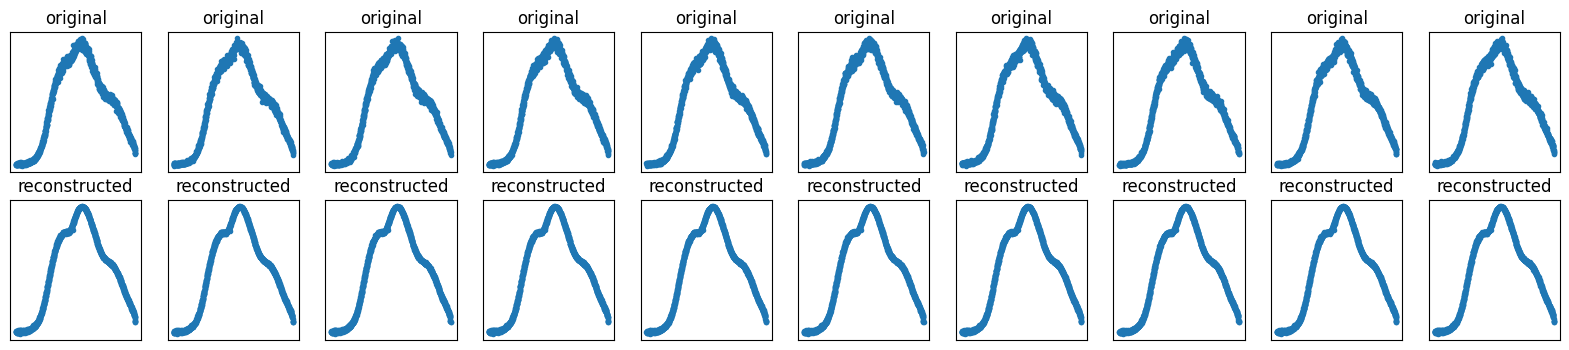

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.plot(x_test[i,:], '.')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(decoded_spectra[i, :], '.')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Data with artefacts

Look at the ability of the autoencoder to clean up a spectra that contains noise from ambient light

In [13]:
train_size = int(light_X.shape[0] * 0.9)
x_train_noisy, x_test_noisy = tf.split(light_X, [train_size, light_X.shape[0] - train_size])

In [14]:
x_train_noisy.shape[0]
train_sample = x_train[:x_train_noisy.shape[0], :]
test_sample = x_test[:x_test_noisy.shape[0], :]

In [15]:
history = autoencoder.fit(x_train_noisy, train_sample,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, test_sample))

Epoch 1/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0137 - val_loss: 0.0022
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss: 0.0024
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 11/50
32/32 [

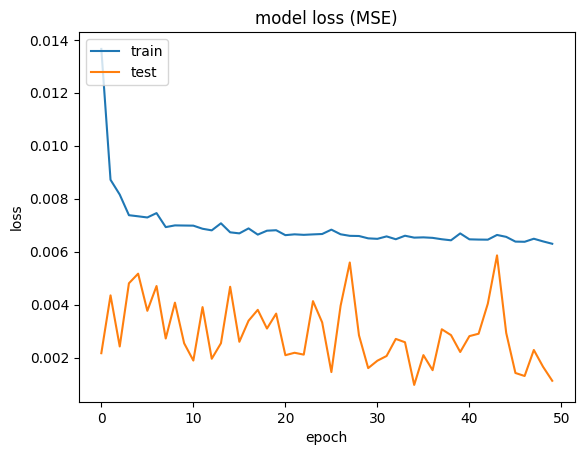

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

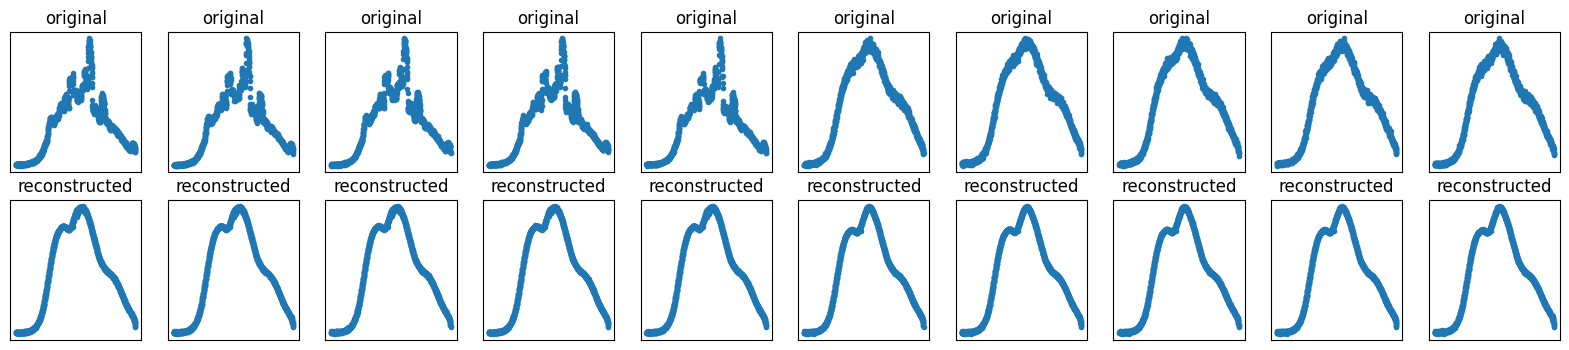

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.plot(x_test_noisy[i,:], '.')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.plot(decoded_imgs[i, :], '.')
  plt.title("reconstructed")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()